# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None
      
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################

for lr in learning_rates:
  for rs in regularization_strengths:
    svm = LinearSVM()
    svm.train(X_train_feats, y_train, learning_rate=lr, reg=rs,
              num_iters=2000, verbose=True)
    
    predictions_train = svm.predict(X_train_feats)
    predictions_val = svm.predict(X_val_feats)
    
    va = np.mean(y_val == predictions_val)
    ta = np.mean(y_train == predictions_train)
    
    results[(lr, rs)] = (ta, va)
    
    if va > best_val:
      best_svm = svm
      best_val = va

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 2000: loss 85.936445
iteration 100 / 2000: loss 85.177583
iteration 200 / 2000: loss 84.413463
iteration 300 / 2000: loss 83.680403
iteration 400 / 2000: loss 82.937988
iteration 500 / 2000: loss 82.198921
iteration 600 / 2000: loss 81.459368
iteration 700 / 2000: loss 80.743512
iteration 800 / 2000: loss 80.019586
iteration 900 / 2000: loss 79.339586
iteration 1000 / 2000: loss 78.621208
iteration 1100 / 2000: loss 77.946811
iteration 1200 / 2000: loss 77.250106
iteration 1300 / 2000: loss 76.569003
iteration 1400 / 2000: loss 75.894787
iteration 1500 / 2000: loss 75.237656
iteration 1600 / 2000: loss 74.572704
iteration 1700 / 2000: loss 73.923154
iteration 1800 / 2000: loss 73.273245
iteration 1900 / 2000: loss 72.635947
iteration 0 / 2000: loss 803.184175
iteration 100 / 2000: loss 727.578841
iteration 200 / 2000: loss 659.195385
iteration 300 / 2000: loss 597.307903
iteration 400 / 2000: loss 541.286736
iteration 500 / 2000: loss 490.630661
iteration 600 / 2000: loss

In [5]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.424


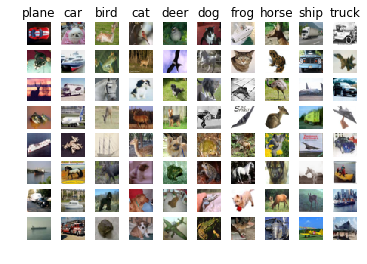

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

The misclassifications are often caused by pictures having simillar range of colors to the ones whose labels they were misclassified as. 

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [7]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [37]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the b est_net variable.                                              #
################################################################################

results = {}
it_no = 100
for i in range(it_no):
  
  print("iteration {}/{}".format(i, it_no))
  rs = 10**np.random.uniform(-2, -6)
  lr = 10**np.random.uniform(0.75, -0.75)
  net = TwoLayerNet(input_dim, hidden_dim, num_classes)
  
  net.train(X_train_feats, y_train, X_train_feats, y_train,
            learning_rate=lr, reg=rs, num_iters=500, verbose=False)
  
  predictions_train = net.predict(X_train_feats)
  predictions_val = net.predict(X_val_feats)
  
  va = np.mean(y_val == predictions_val)
  ta = np.mean(y_train == predictions_train)
  results[(lr, rs)] = (ta, va)

  if va > best_val:
    best_net = net
    best_val = va


################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0/100
iteration 1/100
iteration 2/100
iteration 3/100
iteration 4/100
iteration 5/100
iteration 6/100
iteration 7/100
iteration 8/100
iteration 9/100
iteration 10/100
iteration 11/100
iteration 12/100
iteration 13/100
iteration 14/100
iteration 15/100
iteration 16/100
iteration 17/100
iteration 18/100
iteration 19/100
iteration 20/100
iteration 21/100
iteration 22/100
iteration 23/100
iteration 24/100
iteration 25/100
iteration 26/100
iteration 27/100
iteration 28/100
iteration 29/100
iteration 30/100
iteration 31/100
iteration 32/100
iteration 33/100
iteration 34/100
iteration 35/100
iteration 36/100
iteration 37/100
iteration 38/100
iteration 39/100
iteration 40/100
iteration 41/100
iteration 42/100
iteration 43/100
iteration 44/100
iteration 45/100
iteration 46/100
iteration 47/100
iteration 48/100
iteration 49/100
iteration 50/100
iteration 51/100
iteration 52/100
iteration 53/100
iteration 54/100
iteration 55/100
iteration 56/100
iteration 57/100
iteration 58/100
iterati

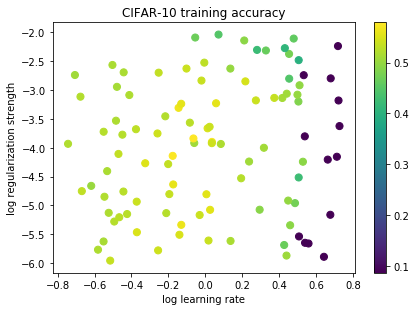

In [38]:
#Visualize stuff

scat_learning_rates = [x[0] for x in results]
scat_reg_str = [x[1] for x in results]


#colors = [results[a]['val_acc_history'][-1] for a in results]
colors = [results[a][1] for a in results]

# Visualize the cross-validation results

x_scatter = np.log10(scat_learning_rates)
y_scatter = np.log10(scat_reg_str)

plt.subplots_adjust(bottom=0, right=1, top=2, hspace=0.3)

# plot training accuracy
marker_size = 50
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

plt.show()

In [39]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.565
